Recency, Frequency, Monetary Value (RFM): This is a commonly used method for segmentation in retail.
- Recency: Calculate the number of days between the customer's latest order date and the maximum invoice date in the dataset.
- Frequency: Count the number of purchases for each customer.
- Monetary Value: Calculate the total revenue generated by each customer.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import pi

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# Import Dataset
retail = pd.read_csv('../data/cleaning_data.csv')

In [3]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledQuantity
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0


In [4]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392732 entries, 0 to 392731
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   InvoiceNo          392732 non-null  int64  
 1   StockCode          392732 non-null  object 
 2   Description        392732 non-null  object 
 3   Quantity           392732 non-null  int64  
 4   InvoiceDate        392732 non-null  object 
 5   UnitPrice          392732 non-null  float64
 6   CustomerID         392732 non-null  int64  
 7   Country            392732 non-null  object 
 8   CancelledQuantity  392732 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 27.0+ MB


# 1. RFM Feature Engineering

### 1.1 Formating Data

In [5]:
# Change CustomerID's datatype to 'str'
retail['CustomerID'] = retail['CustomerID'].astype('str')

retail['CustomerID'].dtypes

dtype('O')

In [6]:
# Change InvoiceDate's datatype to 'datetime'
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])

retail['InvoiceDate'].dtypes

dtype('<M8[ns]')

In [7]:
# Add columns 'Date' and NetSales
retail['Date'] = retail['InvoiceDate'].dt.date

retail['NetSales'] = (retail['Quantity'] - retail['CancelledQuantity']) * retail['UnitPrice']

retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledQuantity,Date,NetSales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,2010-12-01,20.34


### 1.2 Recency: Calculate the number of days between the customer's latest order date and the maximum invoice date in the dataset.

In [8]:
# Get the most recent date
recent_date = max(retail['Date'])

recent_date

datetime.date(2011, 12, 9)

In [9]:
# Calculate recency for each customer
recency = retail.groupby('CustomerID').agg({'Date': 'max'})

recency['recency'] = (recent_date - recency['Date']).dt.days

recency.drop(columns = 'Date', inplace = True)

recency.head()

,recency
CustomerID,
12346,325
12347,2
12348,75
12349,18
12350,310


### 1.3 Frequency: Count the number of purchases for each customer.

Typically, the "Frequency" in RFM analysis refers to the number of orders placed by a customer. However, given that the majority of customers in this case are wholesalers, it's more insightful to consider the number of transactions (defined as each unique item within an order) rather than just the number of orders. The size or complexity of the orders — represented by the number of unique items per order — can provide crucial information about customer behavior in a wholesale context.

To accommodate both perspectives, I'll create two distinct features: 'frequency_order' to represent the number of orders, and 'frequency_item' to represent the total number of unique items across all orders. This approach allows for a more comprehensive understanding of customer behavior, which should subsequently enhance the effectiveness of the segmentation.

In [10]:
frequency_order = retail.groupby('CustomerID').agg({'StockCode': 'nunique'})

frequency_order.rename(columns = {'StockCode': 'frequency_item'}, inplace = True)

frequency_order.head()

,frequency_item
CustomerID,
12346,1
12347,103
12348,22
12349,73
12350,17


In [11]:
frequency_transaction = retail.groupby('CustomerID').agg({'InvoiceNo': 'nunique'})

frequency_transaction.rename(columns = {'InvoiceNo': 'frequency_order'}, inplace = True)

frequency_transaction.head()

,frequency_order
CustomerID,
12346,1
12347,7
12348,4
12349,1
12350,1


### 1.4 Monetary Value: Calculate the total revenue generated by each customer.

When calculating the Monetary value for the RFM analysis, it's generally a good practice to subtract the value of cancelled orders. The reason is that these orders did not contribute to the revenue, and therefore they should not be included in the calculation of Monetary value

In [12]:
monetary = retail.groupby('CustomerID').agg({'NetSales': 'sum'})

monetary.rename(columns = {'NetSales': 'monetary'}, inplace = True)

monetary.head()

,monetary
CustomerID,
12346,0.00
12347,4310.00
12348,1797.24
12349,1757.55
12350,334.40


### 1.5 Combine the four derived features in one dataframe

In [13]:
# Check wheather the number of customers are the same
recency.shape, frequency_order.shape, frequency_transaction.shape, monetary.shape

((4339, 1), (4339, 1), (4339, 1), (4339, 1))

As the number for each tables are the same, we could put them together.

In [14]:
retail_rfm = pd.concat([recency, frequency_order, frequency_transaction, monetary], axis = 1, join = 'inner')

# retail_rfm = pd.concat([recency, frequency_transaction, monetary], axis = 1, join = 'inner')

retail_rfm

,recency,frequency_item,frequency_order,monetary
CustomerID,,,,
12346,325,1,1,0.00
12347,2,103,7,4310.00
12348,75,22,4,1797.24
12349,18,73,1,1757.55
12350,310,17,1,334.40
...,...,...,...,...
18280,277,10,1,180.60
18281,180,7,1,80.82
18282,7,12,2,176.60


# 2. Customer Segmentation

### 2.1 Model Building

In [15]:
# Scale data
sc = StandardScaler()

retail_rfm_sc = sc.fit_transform(retail_rfm)

retail_rfm_sc

array([[ 2.32967293, -0.70868663, -0.42467487, -0.23105081],
       [-0.90044877,  0.48633557,  0.35408019,  0.28495612],
       [-0.17042126, -0.46265265, -0.03529734, -0.01587951],
       ...,
       [-0.85044688, -0.57981169, -0.29488236, -0.2099077 ],
       [-0.89044839,  2.3608802 ,  1.52221279,  0.01384656],
       [-0.5004337 , -0.0291642 , -0.16508985, -0.0110858 ]])

In [16]:
# Use Silhouette Score to decide the number of clusters
silhouette_list = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state = 42)
    kmeans.fit(retail_rfm_sc)
    silhouette_list.append(silhouette_score(retail_rfm_sc, kmeans.labels_))
    
silhouette_list

[0.9097933829372413,
 0.47007234975495565,
 0.5163045913402023,
 0.5189845625613553,
 0.508842079667922,
 0.4377595668893417,
 0.42885959267433993,
 0.40682883802135095,
 0.406667122233257]

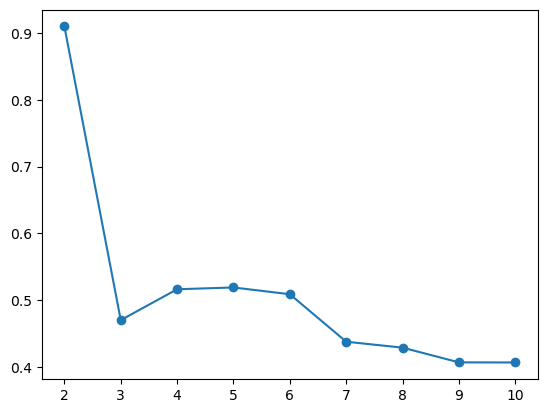

In [17]:
plt.plot(range(2, 11), silhouette_list, marker = 'o')

In [18]:
# Use Interia to decide the number of clusters
inertia_list = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(retail_rfm_sc)
    inertia_list.append(kmeans.inertia_)
    
inertia_list

[12449.276408048154,
 8605.41375222054,
 6383.747747008249,
 5192.8698517257135,
 4138.339217866539,
 3552.053598018057,
 3119.593079766565,
 2714.763043282638,
 2498.298602213481]

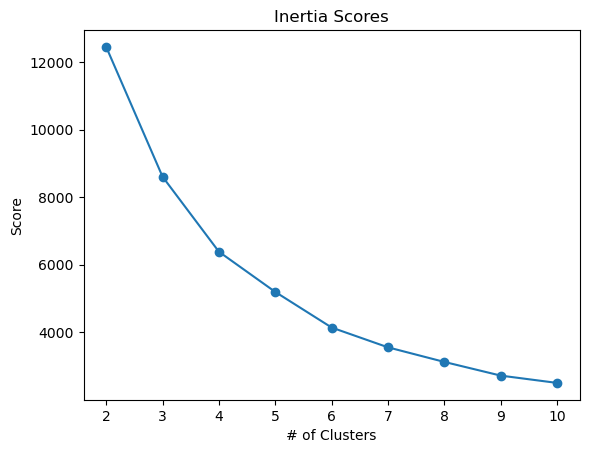

In [19]:
plt.plot(range(2, 11), inertia_list, marker = 'o')
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Inertia Scores');

The silhouette score is highest at 2, suggesting that clusters optimally separate the data. On the other hand, the elbow method suggests that adding clusters up to 8 continues to significantly improve the within-cluster sum of squares(inertia). Therefore, I consider two clusters as a high-level separation and the 8-cluster solution provides more granular, specific segmentation.

### 2.2 High-level separation

In [20]:
# Build k-means with cluster = 2
km2 = KMeans(n_clusters = 2, random_state = 42)

km2.fit(retail_rfm_sc)

KMeans(n_clusters=2, random_state=42)

In [21]:
retail_rfm['cluster'] = km2.labels_

In [22]:
retail_rfm

,recency,frequency_item,frequency_order,monetary,cluster
CustomerID,,,,,
12346,325,1,1,0.00,0
12347,2,103,7,4310.00,0
12348,75,22,4,1797.24,0
12349,18,73,1,1757.55,0
12350,310,17,1,334.40,0
...,...,...,...,...,...
18280,277,10,1,180.60,0
18281,180,7,1,80.82,0
18282,7,12,2,176.60,0


#### Segment Profiling

In [23]:
# Segment Profiling
retail_rfm_mean = retail_rfm.groupby('cluster').mean()

retail_rfm_mean

,recency,frequency_item,frequency_order,monetary
cluster,,,,
0,92.358547,58.964377,3.992366,1557.884588
1,6.375000,743.687500,79.812500,102437.096250


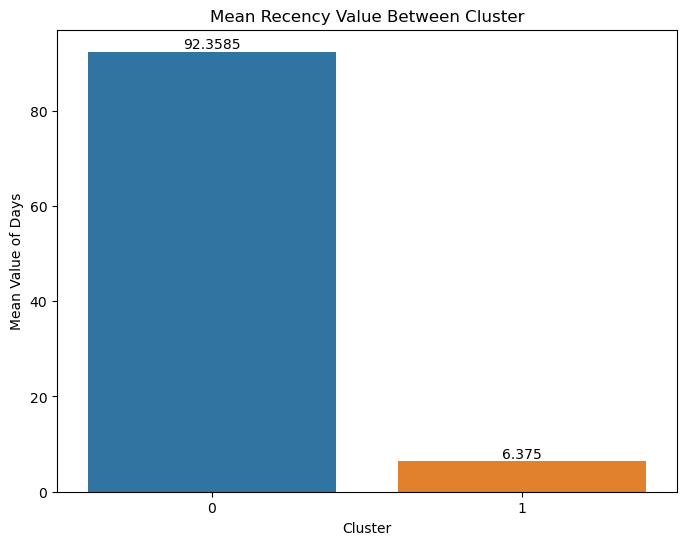

In [24]:
plt.figure(figsize = (8, 6))
ax = sns.barplot(y = 'recency', x = retail_rfm_mean.index, data = retail_rfm_mean)
ax.bar_label(ax.containers[0])
plt.title('Mean Recency Value Between Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Value of Days');

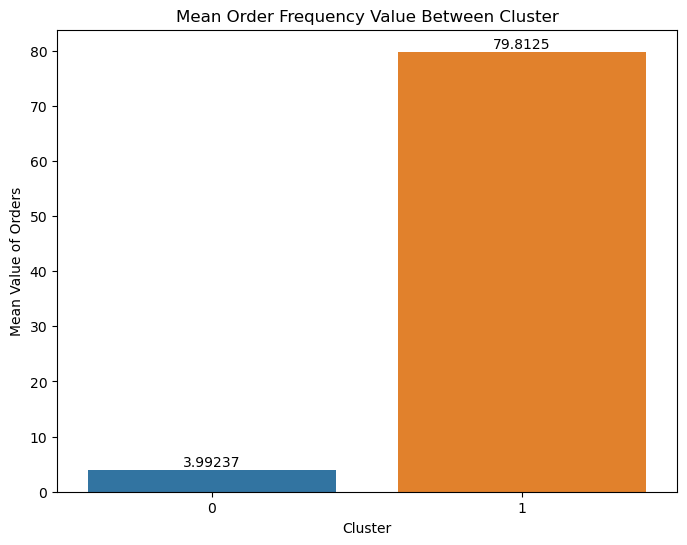

In [25]:
plt.figure(figsize = (8, 6))
ax = sns.barplot(y = 'frequency_order', x = retail_rfm_mean.index, data = retail_rfm_mean)
ax.bar_label(ax.containers[0])
plt.title('Mean Order Frequency Value Between Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Value of Orders');

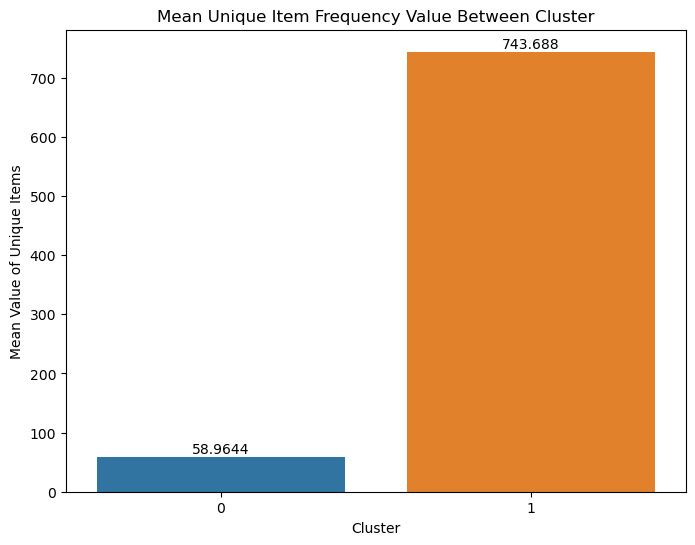

In [26]:
plt.figure(figsize = (8, 6))
ax = sns.barplot(y = 'frequency_item', x = retail_rfm_mean.index, data = retail_rfm_mean)
ax.bar_label(ax.containers[0])
plt.title('Mean Unique Item Frequency Value Between Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Value of Unique Items');

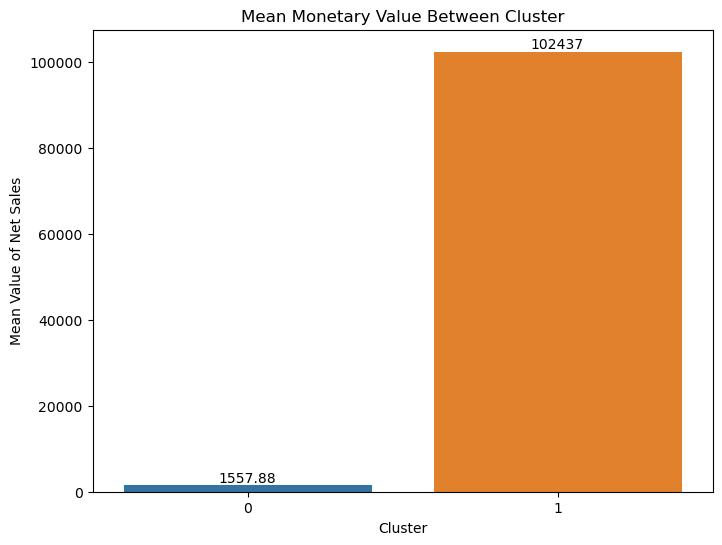

In [27]:
plt.figure(figsize = (8, 6))
ax = sns.barplot(y = 'monetary', x = retail_rfm_mean.index, data = retail_rfm_mean)
ax.bar_label(ax.containers[0])
plt.title('Mean Monetary Value Between Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Value of Net Sales');

In [28]:
retail_rfm.groupby('cluster').sum()

,recency,frequency_item,frequency_order,monetary
cluster,,,,
0,399266,254903,17259,6734735.074
1,102,11899,1277,1638993.540


In [29]:
retail_rfm.groupby('cluster').count()

,recency,frequency_item,frequency_order,monetary
cluster,,,,
0,4323,4323,4323,4323
1,16,16,16,16


The segmentation has resulted in two distinct clusters. Cluster 1, though smaller in size with only 16 customers, shows high activity with a greater average order count, a larger average quantity of unique items, and a higher average total of spend on our website. These customers appear to be particularly valuable to our business.

However, the majority of our customers fall into Cluster 0, which, despite its lower average order count and quantity, still represents a significant share of the company's total revenue due to its sheer size. To gain a more detailed understanding of the varying customer behaviors within this larger group, it may be beneficial to carry out a secondary segmentation specifically for Cluster 0. This approach will help identify distinct subgroups within this cluster, thereby enabling more targeted marketing strategies and customer relationship management.

### 2.3 Secondary Segmentation

In [30]:
# Build k-means with cluster = 8
km_sec = KMeans(n_clusters = 8, random_state = 42)

km_sec.fit(retail_rfm_sc)

KMeans(random_state=42)

In [31]:
features = list(retail_rfm.columns)[: 4]
features

['recency', 'frequency_item', 'frequency_order', 'monetary']

In [32]:
retail_rfm['cluster_sec'] = km_sec.labels_

retail_rfm

,recency,frequency_item,frequency_order,monetary,cluster,cluster_sec
CustomerID,,,,,,
12346,325,1,1,0.00,0,1
12347,2,103,7,4310.00,0,0
12348,75,22,4,1797.24,0,3
12349,18,73,1,1757.55,0,3
12350,310,17,1,334.40,0,1
...,...,...,...,...,...,...
18280,277,10,1,180.60,0,1
18281,180,7,1,80.82,0,1
18282,7,12,2,176.60,0,3


In [33]:
# calculate mean value of all metrics
retail_rfm_mean_sec = retail_rfm.drop(columns = 'cluster').groupby('cluster_sec').mean().reset_index()

retail_rfm_mean_sec

,cluster_sec,recency,frequency_item,frequency_order,monetary
0,0,28.226770,108.433628,6.774336,2617.206936
1,1,252.870936,24.089655,1.514286,468.848405
2,2,3.000000,325.000000,60.000000,242999.283333
3,3,52.990132,31.134868,2.393327,756.087271
4,4,0.666667,1626.000000,178.333333,69223.220000
5,5,9.100000,604.600000,56.200000,70232.603000
6,6,17.463415,275.185366,11.385366,4936.425610
7,7,10.450704,137.464789,30.577465,17915.181831


In [34]:
# Scale data for radar graph
scaler = StandardScaler()

retail_rfm_mean_sec_sc = pd.DataFrame(scaler.fit_transform(retail_rfm_mean_sec[features]), columns = features)

In [35]:
retail_rfm_mean_sec_sc

,recency,frequency_item,frequency_order,monetary
0,-0.234353,-0.566554,-0.660259,-0.625167
1,2.593139,-0.735374,-0.755090,-0.652845
2,-0.551870,-0.133081,0.299324,2.471683
3,0.077332,-0.721272,-0.739242,-0.649144
4,-0.581239,2.470959,2.432705,0.232920
5,-0.475092,0.426557,0.230815,0.245924
6,-0.369826,-0.232789,-0.577129,-0.595289
7,-0.458092,-0.508446,-0.231123,-0.428083


In [36]:
retail_rfm_mean_sec_sc['cluster'] = retail_rfm_mean_sec['cluster_sec']
retail_rfm_mean_sec_sc

,recency,frequency_item,frequency_order,monetary,cluster
0,-0.234353,-0.566554,-0.660259,-0.625167,0
1,2.593139,-0.735374,-0.755090,-0.652845,1
2,-0.551870,-0.133081,0.299324,2.471683,2
3,0.077332,-0.721272,-0.739242,-0.649144,3
4,-0.581239,2.470959,2.432705,0.232920,4
5,-0.475092,0.426557,0.230815,0.245924,5
6,-0.369826,-0.232789,-0.577129,-0.595289,6
7,-0.458092,-0.508446,-0.231123,-0.428083,7


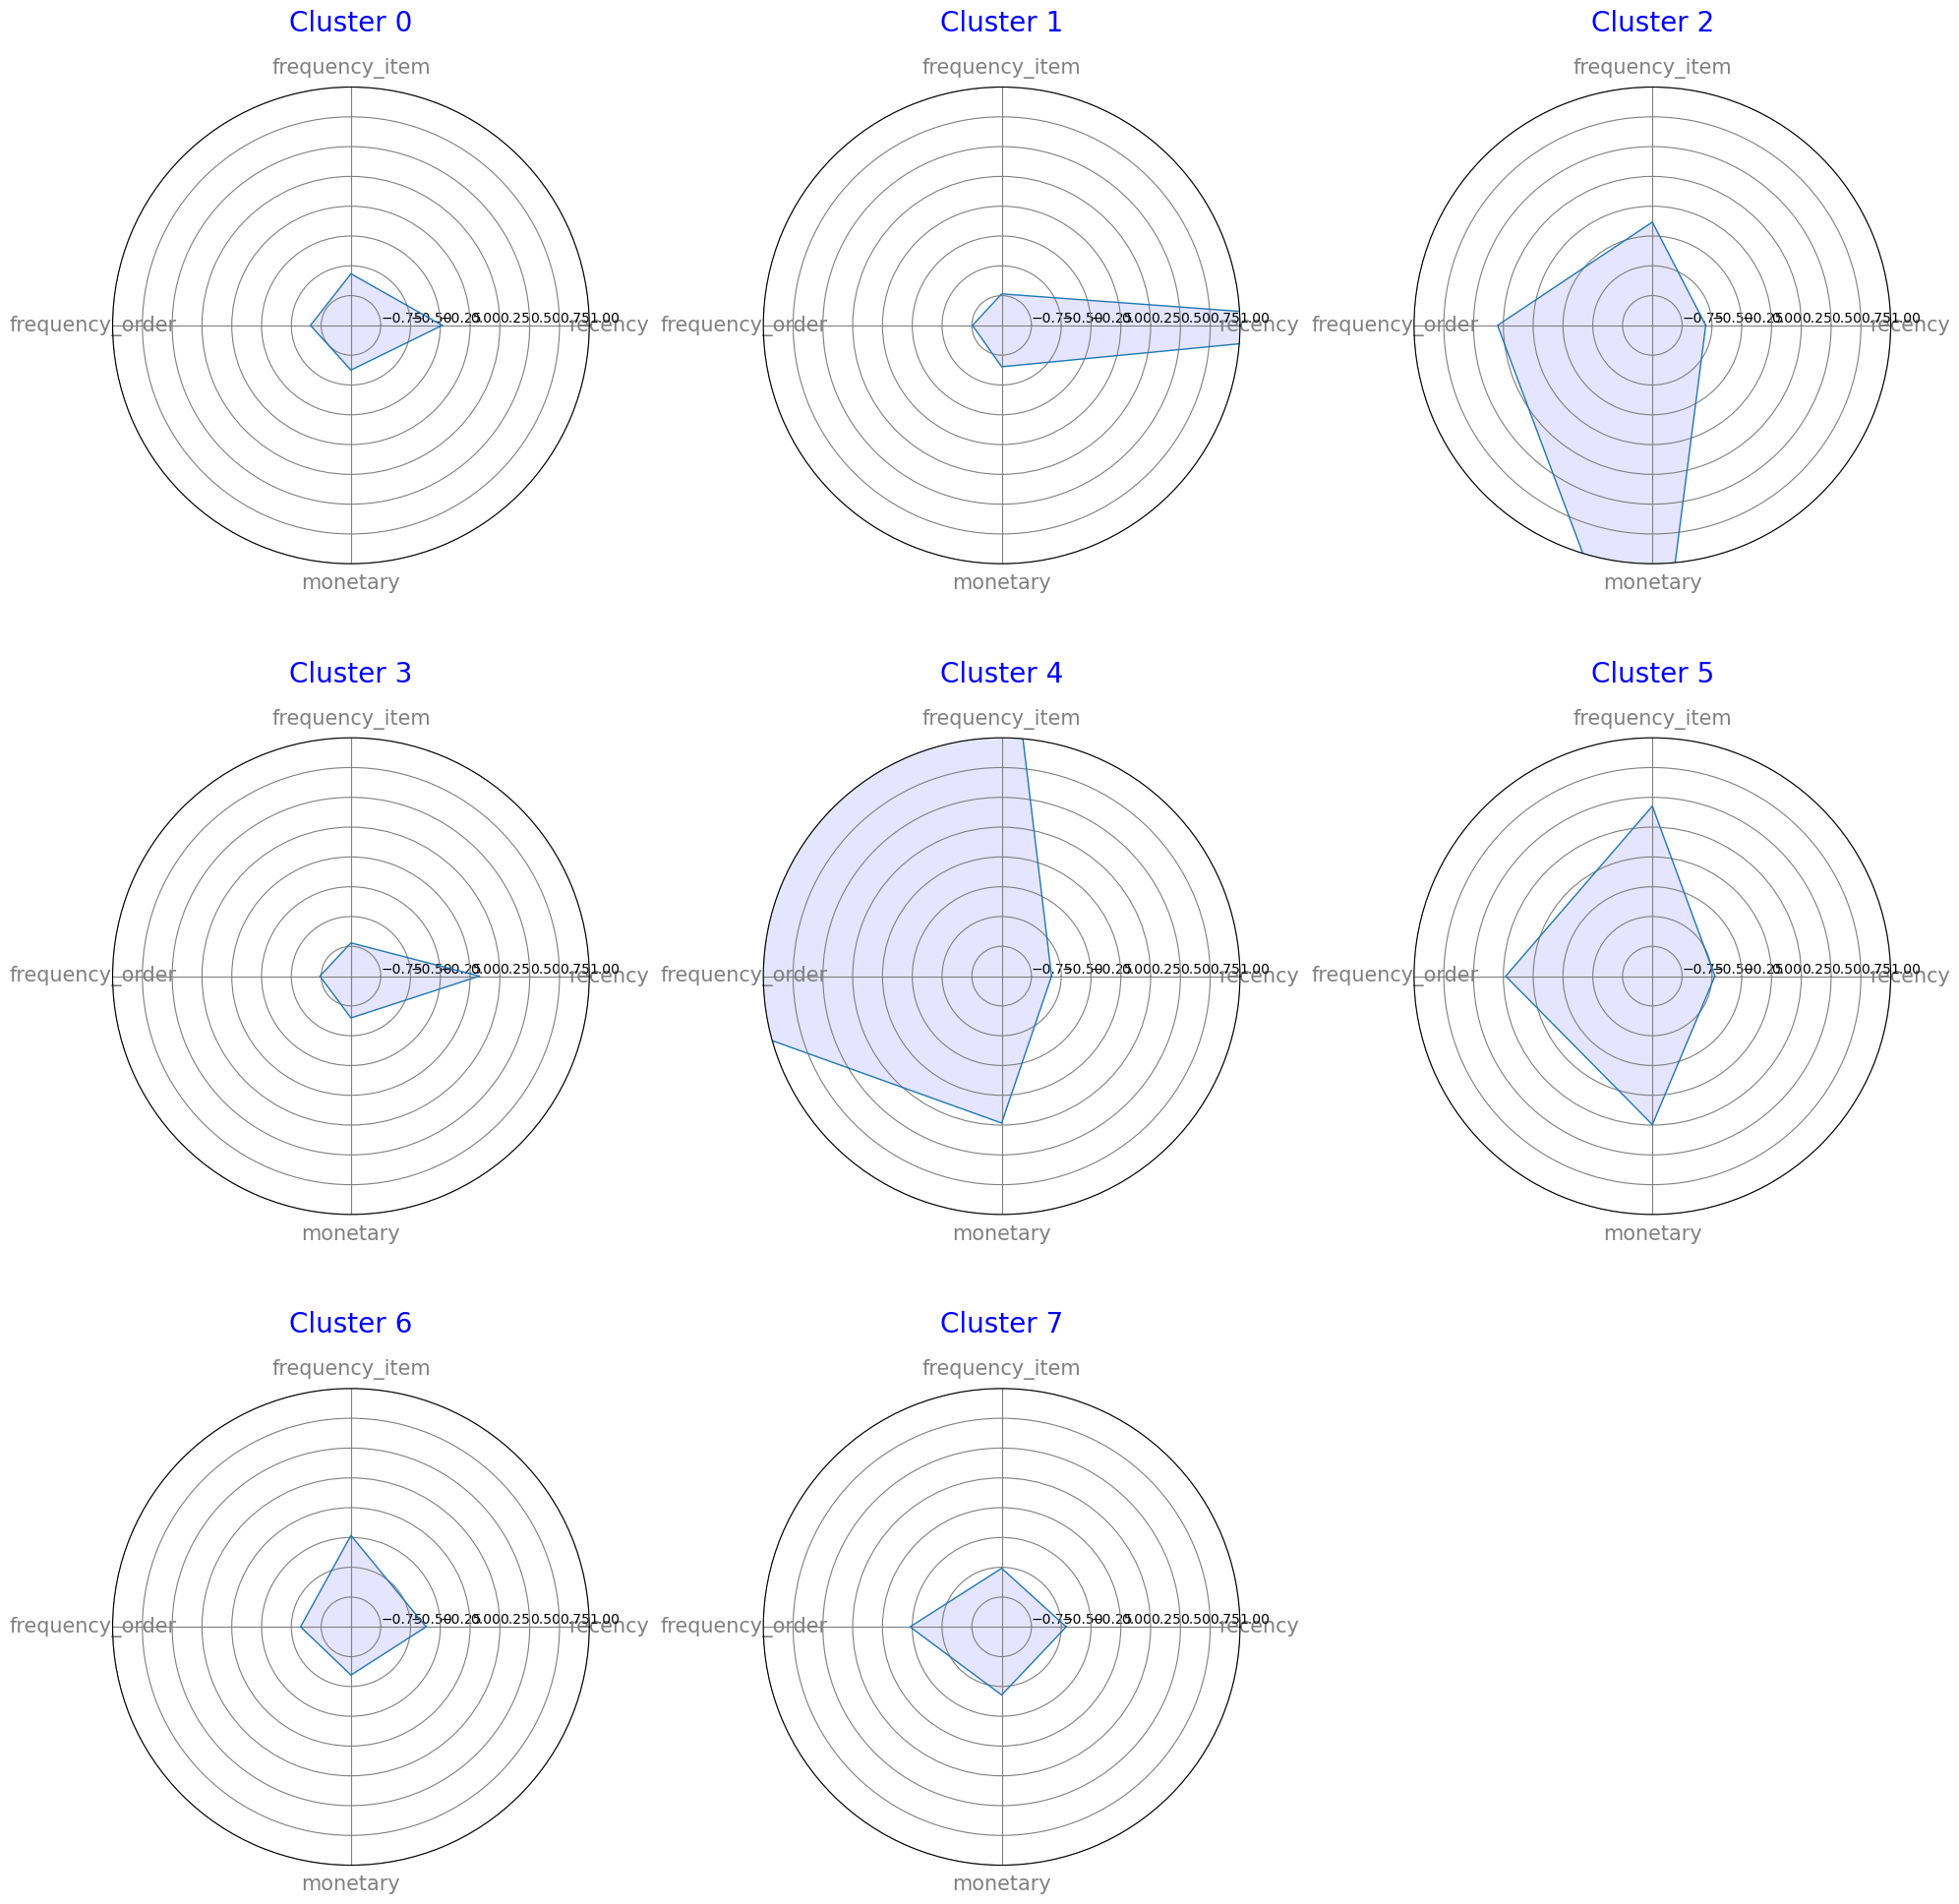

In [41]:
# Create Radar Charts to visulize the characteristics of each cluster.
clusters = retail_rfm_mean_sec_sc['cluster'].unique()
N = len(features)

# Create subplots: adjust the number of rows/columns as needed
fig, axes = plt.subplots(nrows=int(np.ceil(len(clusters)/3)), ncols=3, subplot_kw=dict(polar=True), figsize=(20, 20))

# Flatten the axes
axes = axes.flatten()

# Loop over clusters and axes
for cluster, ax in zip(clusters, axes):
    # Select data for this cluster
    values = retail_rfm_mean_sec_sc[retail_rfm_mean_sec_sc['cluster'] == cluster][features].values.flatten().tolist()
    values += values[:1]

    # Compute angle for each axis
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Draw one axe per variable + add labels
    ax.set_xticks(angles[:-1], features, color = 'grey', size = 8)
    ax.set_xticklabels(features, color='grey', size=15)

    # Draw ylabels
    ax.set_rlabel_position(0)
    ax.yaxis.grid(True, color="grey", linestyle='-')
    ax.xaxis.grid(True, color="grey", linestyle='-')

    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

    ax.set_title(f'Cluster {cluster}', size=20, color='blue', y=1.1)
    ax.set_ylim(-1, 1)
    
if len(clusters) < len(axes):
    for i in range(len(clusters), len(axes)):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('../graph/cluster_8.png')
plt.show()

Looking at the graphs, it's evident that each cluster exhibits unique characteristics:

Cluster 1 is marked by high recency values, suggesting that customers in this cluster have not made purchases recently.

Cluster 2 stands out due to its high monetary values, implying these customers tend to spend a considerable amount on their purchases, and maintain a moderate frequency of orders.

Cluster 3 exhibits moderate recency values, which suggests these customers have made purchases in the not-too-distant past. However, this cluster scores significantly low on all other metrics, indicating these customers may not be as active or spend as much compared to those in other clusters.

Cluster 4 is characterized by high frequency of both items and orders, and low recency, indicating these customers have made purchases very recently and do so quite frequently. They also provide a moderate amount of monetary value to the total revenue.

Cluster 5 shows low recency (i.e., recent purchases) but moderate values for the other metrics, suggesting these customers have made purchases relatively recently, usually have a higher order frequency, and spend more when they do make a purchase.

The remaining three clusters generally show low values for all metrics, with each cluster having just one feature that isn't as low. These clusters may represent less active or less engaged customers.


### 2.4 Export Data

In [38]:
retail_rfm_export = retail_rfm[['recency', 'frequency_item', 'frequency_order', 'monetary', 'cluster_sec']]

In [39]:
retail_rfm_export.to_csv('../data/customer_seg.csv', index = False)